In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("..")

In [3]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from badseeds import seedbank, fig_5

plt.rcParams["font.family"] = "serif"

In [4]:
# path to config json file containing paths to datasets. change if necessary
CONFIG_PATH = "./config.json"

In [5]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

In [6]:
# Get our gathered seeds
seeds = seedbank.seedbanking(
    config["seeds"]["dir_path"] + "seeds.json", index=False
)
# And our pairings
pair_df = pd.read_csv(config["pairs"]["dir_path"] + "seed_set_pairings.csv")

peak memory: 303.93 MiB, increment: -1.96 MiB


In [7]:
# initialize our dict containing embeddings organized by corpus
corpus_embds = {
    "nyt": {"0": {"PCA": [], "Coherence": []}, "10": {"PCA": [], "Coherence": []}},
    "goodreads_hb": {
        "0": {"PCA": [], "Coherence": []},
        "10": {"PCA": [], "Coherence": []},
    },
    "goodreads_r": {
        "0": {"PCA": [], "Coherence": []},
        "10": {"PCA": [], "Coherence": []},
    },
    "wiki": {"0": {"PCA": [], "Coherence": []}, "10": {"PCA": [], "Coherence": []}},
}

peak memory: 297.47 MiB, increment: -0.08 MiB


Note, in this notebook, we only consider min freq of 10. One can change the min_freq loop to use 0 instead if desired.

Coherence computations are slow and it will seem like it is hanging. If you wish for more verbosity, set the verbose flag to True.

In [8]:
# Can now compute our metrics for each corpus
for i, corpus in enumerate(corpus_embds.keys()):
    for min_freq in [10]:
        for mode in ["PCA", "Coherence"]:
            # something in the coher. methds edits the dframe in place, lets keep original
            seeds_df = seeds.copy()
            print(
                f"Computing {mode}-set similarity metrics for model "
                f"trained on {corpus} with min_freq {min_freq}..."
            )
            # for more verbose output, set verbose to True
            corpus_embds[corpus][str(min_freq)][mode] = fig_5.comp_fig_5_metrics(
                seeds_df, pair_df, config, corpus, mode, min_freq, 42, False
            )
    if i == len(corpus_embds.keys()) - 1:
        print("Done.")
    else:
        print("\n")

Computing PCA-set similarity metrics for model trained on nyt with min_freq 10...
Computing Coherence-set similarity metrics for model trained on nyt with min_freq 10...


Computing PCA-set similarity metrics for model trained on goodreads_hb with min_freq 10...
Computing Coherence-set similarity metrics for model trained on goodreads_hb with min_freq 10...


Computing PCA-set similarity metrics for model trained on goodreads_r with min_freq 10...
Computing Coherence-set similarity metrics for model trained on goodreads_r with min_freq 10...


Computing PCA-set similarity metrics for model trained on wiki with min_freq 10...
Computing Coherence-set similarity metrics for model trained on wiki with min_freq 10...
Done.
peak memory: 1610.23 MiB, increment: 1312.75 MiB


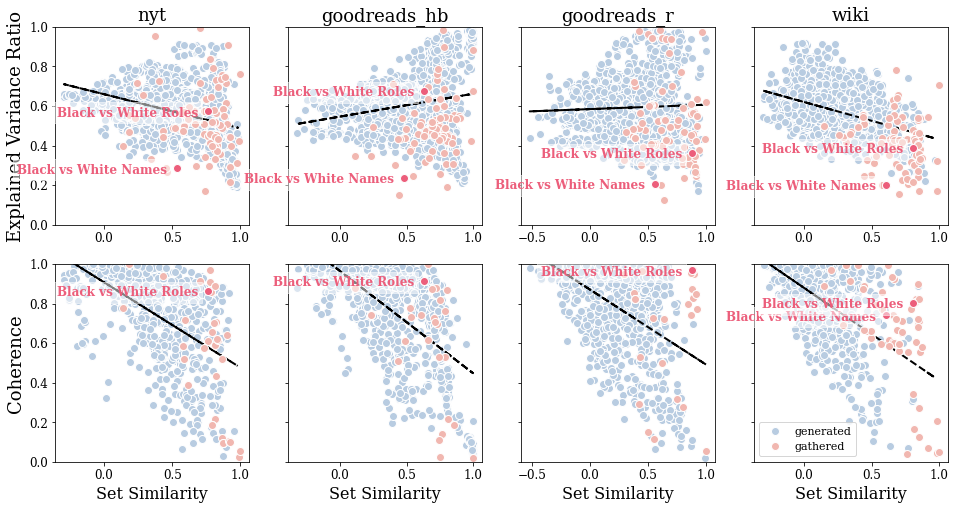

peak memory: 254.58 MiB, increment: 0.23 MiB


In [26]:
# and now we plot
fig, (row_0, row_10) = plt.subplots(2, 4, sharex=False, sharey='row', figsize=(16, 8))

for freq in ["10"]:
    for r, (mode, row) in enumerate(zip(["PCA", "Coherence"], [row_0, row_10])):
        for c, (corpus, ax) in enumerate(zip(corpus_embds.keys(), row)):
            (
                gathered_y_values,
                generated_y_values,
                gathered_set_sim,
                generated_set_sim,
            ) = corpus_embds[corpus][freq][mode]

            # additional processing§
            valid_idx = np.isfinite(generated_set_sim) & np.isfinite(generated_y_values)
            gen_coef = np.polyfit(
                np.array(generated_set_sim)[valid_idx],
                np.array(generated_y_values)[valid_idx],
                1,
            )
            gen_poly1d_fn = np.poly1d(gen_coef)
            # highlighted seed sets
            names_idx = pair_df[
                pair_df["ID_A"] == "white_names-Knoche_et_al_2019"
            ].index.to_list()[0]
            roles_idx = pair_df[
                pair_df["ID_B"] == "caucasian_roles-Manzini_et_al_2019"
            ].index.to_list()[0]

            # generated
            ax.plot(
                generated_set_sim,
                generated_y_values,
                "o",
                markersize=8,
                markerfacecolor="#B8CCE1",
                markeredgecolor="white",
                label="generated",
            )
            # linear fit
            ax.plot(
                generated_set_sim,
                gen_poly1d_fn(generated_set_sim),
                color="black",
                linestyle="dashed",
                linewidth=2,
            )
            # gathered
            ax.plot(
                gathered_set_sim,
                gathered_y_values,
                "o",
                markersize=8,
                markerfacecolor="#F1B7B0",
                markeredgecolor="white",
                label="gathered",
            )

            highlighted_set_sim = [
                gathered_set_sim[idx] for idx in [names_idx, roles_idx]
            ]
            highlighted_y_values = [
                gathered_y_values[idx] for idx in [names_idx, roles_idx]
            ]
            # highlighted gathered
            ax.plot(
                highlighted_set_sim,
                highlighted_y_values,
                "o",
                markersize=8,
                markerfacecolor="#EC5E7B",
                markeredgecolor="white",
            )

            for i, label in enumerate(["Black vs White Names", "Black vs White Roles"]):
                ax.annotate(
                    label,
                    (highlighted_set_sim[i], highlighted_y_values[i]),
                    xytext=(-10,-5),
                    textcoords="offset points",
                    horizontalalignment="right",
                    color="#EC5E7B",
                    weight="heavy",
                    fontsize=12,
                    bbox=dict(facecolor="white", alpha=0.5, edgecolor="white"),
                )

            ax.set_ylim([0, 1])
            ax.tick_params(axis="both", which="major", labelsize=12)
            if r == 1:
                ax.set_xlabel("Set Similarity", fontsize=16)
                if c == 3:
                    ax.legend(loc="lower left", fontsize=11)
            if c == 0:
                ax.set_ylabel(
                    "Explained Variance Ratio" if mode == "PCA" else "Coherence",
                    fontsize=18,
                )
            if r == 0:
                ax.set_title(f"{corpus}", fontsize=18)

# fig.tight_layout()
plt.show()

In [27]:
# save to latex
fig.savefig("images/fig_5.pdf", bbox_inches="tight")